# House Prices Exploration

In this competition, we are trying to figure out the prices for which a bunch of houses have been sold.
A lot of these features can be used out-of-the-box, so let's check what we have.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

# Checking The Data

Let's begin by first loading our training and test set and taking a look at them.

In [2]:
# Id column won't be useful for building the model,
# so let's make it the index of the dataframe
train = pd.read_csv("input/train.csv", index_col=0)
test = pd.read_csv("input/test.csv", index_col=0)

In [3]:
train.shape, test.shape

((1460, 80), (1459, 79))

In [4]:
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Our dataset has 1460 and 1459 houses on our training and test set, respectively. We have a lot of categorial features in this dataset, so it's interesting to break them into dummy variables. To make it easier for us to create and manipulate these variables, let's join the training and test set, so that both will end up with the same columns. We can split them back after we've done all the data cleaning.

Note: model evaluation is based on the log of SalePrice, so we will save it as log too. We need to change it back before exporting our submission file.


In [5]:
# let's remove sale prices of our train before joining, and save them for later use
Y_train = np.log(train.pop('SalePrice'))

all_df = pd.concat((train, test), axis=0)
all_df.shape

(2919, 79)

# Variable Transformations

First thing to notice is that one of the features in the dataset, MSSubClass, is a categorical feature stored as a numeric one.

In [6]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [7]:
all_df['MSSubClass'] = all_df['MSSubClass'].apply(str)
all_df['MSSubClass'].dtypes

dtype('O')

## Creating dummy variables

Now that we have everything together, we need to generate dummy variables for our categorical features. Pandas can help us with the get_dummy_variable function. It generates dummy variables for a series or an entire dataframe. 

In [8]:
all_dummy_df = pd.get_dummies(all_df)

# let's check if everything went alright
all_dummy_df.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65,8450,7,5,2003,2003,196,706,0,150,...,0,0,0,1,0,0,0,0,1,0
2,80,9600,6,8,1976,1976,0,978,0,284,...,0,0,0,1,0,0,0,0,1,0
3,68,11250,7,5,2001,2002,162,486,0,434,...,0,0,0,1,0,0,0,0,1,0
4,60,9550,7,5,1915,1970,0,216,0,540,...,0,0,0,1,1,0,0,0,0,0
5,84,14260,8,5,2000,2000,350,655,0,490,...,0,0,0,1,0,0,0,0,1,0



Column order looks a little messy. They are in alphabetical order now, but that shouldn't be a problem. But we do have a lot of columns, which is possibly a bigger deal to be worried with.

Now that we have our dummy variables, we should check for NaN values in our columns. For the categorical features, pandas' get_dummy_variables takes care of this for us. For example, for a feature X which could get values a, b or c, if an individual has NaN for X, all 3 resulting columns (X_a, X_b, X_c) will be assigned 0. (Note: it can be useful to create a new column for missing values, e.g., X_missing, because not being assigned to any label could be informative; we should get back at this later)

## Missing Values

Since there's no missing values for our categorical features, we just need to check the numerical ones.


In [9]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(15)

LotFrontage             486
GarageYrBlt             159
MasVnrArea               23
BsmtHalfBath              2
BsmtFullBath              2
BsmtFinSF2                1
GarageCars                1
TotalBsmtSF               1
BsmtUnfSF                 1
GarageArea                1
BsmtFinSF1                1
Condition1_Artery         0
Condition2_Feedr          0
Condition2_Artery         0
Neighborhood_Somerst      0
dtype: int64

We need to take care of these missing values. For now, let's just assign the mean for all missing values. There's probably better ways to deal with that, but let's just do the easy way now.

In [10]:
mean_columns = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_columns)

all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

SaleCondition_Partial    0
Neighborhood_NridgHt     0
Neighborhood_SWISU       0
Neighborhood_Sawyer      0
Neighborhood_SawyerW     0
Neighborhood_Somerst     0
Neighborhood_StoneBr     0
Neighborhood_Timber      0
Neighborhood_Veenker     0
Condition1_Artery        0
dtype: int64

## Normalize numerical features

Since we are going to do regression on this dataset, it's recommended to standardize our numerical features. So we are going to get all numerical features, subtract by the mean and divide by the standard deviation. This will make them all scaled similarly.

First let's break our dataset into train and test again

In [11]:
dummy_train_df = all_dummy_df.loc[train.index]
dummy_test_df = all_dummy_df.loc[test.index]

dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

Now let's get our numerical features

In [12]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index([u'LotFrontage', u'LotArea', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF',
       u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath',
       u'FullBath', u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr',
       u'TotRmsAbvGrd', u'Fireplaces', u'GarageYrBlt', u'GarageCars',
       u'GarageArea', u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch',
       u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal', u'MoSold',
       u'YrSold'],
      dtype='object')

Now we apply the normalization both on our train and test set.

In [13]:
train_numeric_col_means = dummy_train_df.loc[:, numeric_cols].mean()
train_numeric_col_std = dummy_train_df.loc[:, numeric_cols].std()

dummy_train_df.loc[:, numeric_cols] = (dummy_train_df.loc[:, numeric_cols] - train_numeric_col_means) / train_numeric_col_std

In [14]:
test_numeric_col_means = dummy_test_df.loc[:, numeric_cols].mean()
test_numeric_col_std = dummy_test_df.loc[:, numeric_cols].std()

dummy_test_df.loc[:, numeric_cols] = (dummy_test_df.loc[:, numeric_cols] - test_numeric_col_means) / test_numeric_col_std

Now let's check the histogram of a variable to see if everything went alright.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f26bc5f0ed0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f26bc5f0ed0>)

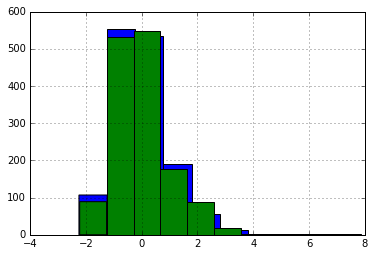

In [15]:
dummy_train_df['GrLivArea'].hist(), dummy_test_df['GrLivArea'].hist()

There are some outliers but we are going to just leave it like that for now.

And this is all the data preparation we need. There's still a lot of things that could be done, but let just proceed for building the model and checking how well we can do with this.


# Building The Model

Let's try building some models now. I'll just try some available in sklearn library and see what works best. 


In [16]:
all_features = list(dummy_train_df.describe().columns.values)

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from operator import itemgetter

Ok, now that we have everything prepared, we are going to follow some steps for each regressor we are going to use.

### Algorithm

1 - find the most relevant/important features for the model\* <br />
2 - tune the hyper-parameters <br />
3 - cross validate the model on our training data 

\*This step will vary depending on the regressor. Tree-based regressor have a built-in feature_importances field which we can use to get the most relevant features. For other approach-based regressors, we are going to use the SelectKBest class to get the most relevant features of our dataset for doing regression on the target.

### 1 - Finding the best features

As mentioned, the way to select features depends on the regressor. Here, we are going to have two approaches, each one defining a function

In [18]:
# we are going to use this function for tree-based regressors
def get_best_threshold(regressor, X, Y, initial_threshold=0.1, limit_features=100, threshold_increase=-0.0001, title=""):

    base = np.sqrt(-cross_val_score(regressor, X, Y, cv=10, scoring='neg_mean_squared_error'))
    sfm = SelectFromModel(regressor, threshold=initial_threshold)

    n_features = sfm.fit_transform(X, Y).shape[1]
    last_n_features = n_features
    threshold_results = []
    
    f = open("output/{0}.txt".format(title),"w")
    f.write("Result: {0}, N_features: All\n".format(np.mean(base)))
    
    while n_features < limit_features:
        sfm.threshold += threshold_increase
        X_new = sfm.fit_transform(X, Y)
        n_features = X_new.shape[1]

        if n_features > last_n_features:
            
            last_n_features = n_features
            selected_features_score = np.sqrt(-cross_val_score(regressor, X_new, Y, cv=10, scoring='neg_mean_squared_error'))
            f.write("Result: {0}, Threshold: {1}, N_features: {2}\n".format(np.mean(selected_features_score), sfm.threshold, n_features))
            threshold_results.append((sfm.threshold, np.mean(selected_features_score)))
            
    better_threshold = min(threshold_results, key = itemgetter(1))[0]
    f.close()
    return better_threshold

In [19]:
# we are going to use this function for non-tree-based regressors
def get_best_features(regressor, X, Y, limit_features=100, feature_increase=3, title=""):

    k_features = 10
    k_features_results = []
    f = open("output/{0}.txt".format(title),"w")

    # use SelectKBest to iterate over important features
    while k_features < limit_features:
        selector = SelectKBest(f_regression, k=k_features)
        X_new = selector.fit_transform(X, Y)
        selected_features_score = np.sqrt(-cross_val_score(regressor, X_new, Y, cv=10, scoring='neg_mean_squared_error'))
        f.write("Result: {0},  N_features: {1}\n".format(np.mean(selected_features_score), k_features))
        k_features_results.append((k_features, np.mean(selected_features_score)))
        k_features += feature_increase
        
    f.close()
    best_k_features = min(k_features_results, key = itemgetter(1))[0]
    return best_k_features

### 2 - Tuning the hyper-parameters

Here we are going to use sklearn's GridSearchCV to exhaustively search a for the best params in a dictionary. You need to pass it values to be tested. If you don't don't know which range of values to use for a parameter, an idea is to check the default value, and work from there. 


In [20]:
def get_hyper_parameters(alg, parameters, X, Y, title="GridSearch"):
    
    f = open("output/{0}.txt".format(title),"w")
    gs = GridSearchCV(alg, parameters, n_jobs=3, cv=5)                
    gs.fit(X, Y)
    for param in gs.best_params_.keys():
        f.write("Param: {0},  Value: {1}\n".format(param, gs.best_params_[param]))
    f.close()
        
    return gs.best_params_


### 3 - Cross-validating

We don't have any code for this, it will be done after we build the model. One important thing to notice is the number of CV folds to use, and the scorer parameter. Here we are going to use the 'neg_mean_squared_error' because this is the scoring function which Kaggle will validate your results, so it's good to have similar score range while cross-validating, so we can have an idea how well we are going to do on the leaderboard

In [21]:
# some of these parameters have already been tuned
# we are going to declare them here so we don't have
# grid search everytime we run this notebook

RF_data = {
    #all features                   #selected features
    'n_estimators':       300,     'n_estimators_all':      300,   
    'max_features':       0.5,     'max_features_all':       0.2,  
    'min_samples_leaf':   1,       'min_samples_leaf_all':   1,
    'min_samples_split':  1,       'min_samples_split_all':  4,
    'max_depth':          None,    'max_depth_all':          None,
    'best_threshold':     0.0036
}

GB_data = {
    #all features                  #selected features
    'n_estimators':       300,     'n_estimators_all':       300,    
    'max_features':       'sqrt',  'max_features_all':       'sqrt',     
    'min_samples_leaf':   1,       'min_samples_leaf_all':   1,
    'min_samples_split':  1,       'min_samples_split_all':  1,
    'max_depth':          3,       'max_depth_all':          3,         
    'learning_rate':      0.1,     'learning_rate_all':      0.1, 
    'best_threshold':     0.0024
}

RR_data = {
    'alpha': 0.1,                   'alpha_all': 0.1,          
    'best_n_features': 287,  
}

XGB_data = {
    'n_estimators':       100,
    'learning_rate':      0.1,
    'best_n_features' :   241,
    
}

## Random Forest Regressor

In [22]:
from sklearn.ensemble.forest import RandomForestRegressor


In [23]:
alg = RandomForestRegressor(random_state=1)

# First step: get the best features for our train and test
# this step was previously done so we can skip it
#best_threshold = get_best_threshold(alg, dummy_train_df[all_features], Y_train, title="RF_threshold")
#RF_data['best_threshold'] = best_threshold

sfm = SelectFromModel(alg, threshold=RF_data['best_threshold'])
X_train_new = sfm.fit_transform(dummy_train_df[all_features], Y_train)
X_test_new = sfm.transform(dummy_test_df[all_features])

# Second step: grid search for the best params
# this step was previously done so we can skip it
#parameters = {
#    'n_estimators' : [5, 10, 25, 40, 65, 80, 100, 150, 200, 300],
#    'max_features' : ["auto", "sqrt", "log2", 0.2, 0.5],
#    'min_samples_leaf' : [1, 5, 10, 25, 50],
#    'min_samples_split' : [1, 2, 4, 8] ,
#    'max_depth': [None, 3, 5, 10]
#    }

#bp = get_hyper_parameters(alg, parameters, X_train_new, Y_train, "RF_grid_selected")
#bp2 = get_hyper_parameters(alg, parameters, dummy_train_df[all_features], Y_train, "RF_grid_all")
#let's store this information for later use
#RF_data['n_estimators'] = bp['n_estimators']
#RF_data['max_features'] = bp['max_features']
#RF_data['min_samples_split'] = bp['min_samples_split']
#RF_data['min_samples_leaf'] = bp['min_samples_leaf']
#RF_data['max_depth'] = bp['max_depth']

# Third step: cross-validate, here we compare the cross-validated
# scores both using all the features and just the selected features
regr_selected = RandomForestRegressor(random_state=1, n_estimators=RF_data['n_estimators'], max_features=RF_data['max_features'],
                            min_samples_split=RF_data['min_samples_split'], min_samples_leaf=RF_data['min_samples_leaf'],
                            max_depth=RF_data['max_depth'])
regr_all = RandomForestRegressor(random_state=1, n_estimators=RF_data['n_estimators_all'], 
                            max_features=RF_data['max_features_all'], min_samples_split=RF_data['min_samples_split_all'], 
                            min_samples_leaf=RF_data['min_samples_leaf_all'], max_depth=RF_data['max_depth_all'])

selected_features_score = np.sqrt(-cross_val_score(regr_selected, X_train_new, Y_train, cv=8, scoring='neg_mean_squared_error'))
all_features_score = np.sqrt(-cross_val_score(regr_all, dummy_train_df[all_features], Y_train, cv=8, scoring='neg_mean_squared_error'))

selected_features_score = np.mean(selected_features_score)
all_features_score = np.mean(all_features_score)

# Last step: run our model and generate submission files
submission =  pd.DataFrame()
submission["Id"] = test.index

regr_all.fit(dummy_train_df[all_features], Y_train)
predictions = regr_all.predict(dummy_test_df)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/rf_whole_submission.csv", index=False)

regr_selected.fit(X_train_new, Y_train)
predictions = regr_selected.predict(X_test_new)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/rf_subset_submission.csv", index=False)

np.mean(selected_features_score), np.mean(all_features_score)


(0.13553416885231812, 0.13637899811891435)

It's seems that selecting the best features gives us just slightly better results than just using all the generated features. As expected the impact is not so big for tree based approaches, but it should be worth repeating this test for regressors with different approaches.

## Gradient Boosting Regressor

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

In [25]:
alg = GradientBoostingRegressor(random_state=1)

# First step: get the best features for our train and test
# this step was previously done so we can skip it
#best_threshold = get_best_threshold(alg, dummy_train_df[all_features], Y_train, title="GB_threshold")
#GB_data['best_threshold'] = best_threshold

sfm = SelectFromModel(alg, threshold=GB_data['best_threshold'])
X_train_new = sfm.fit_transform(dummy_train_df[all_features], Y_train)
X_test_new = sfm.transform(dummy_test_df[all_features])

# Second step: grid search for the best params
# this step was previously done so we can skip it
#parameters = {
#    'n_estimators' : [5, 10, 25, 40, 65, 80, 100, 150, 200, 300],
#    'max_features' : ["auto", "sqrt", "log2", 0.2, 0.5],
#    'min_samples_leaf' : [1, 5, 10, 25, 50],
#    'min_samples_split' : [1, 2, 4, 8],
#    'max_depth': [None, 3, 5, 10],
#    'learning_rate' : [0.05, 0.08, 0.1, 0.15, 0.2]
#    }
#
#bp = get_hyper_parameters(alg, parameters, X_train_new, Y_train, "GB_grid_selected")
#bp = get_hyper_parameters(alg, parameters, X_train_new, Y_train, "GB_grid_all")
#let's store this information for later use
#GB_data['n_estimators'] = bp['n_estimators']
#GB_data['max_features'] = bp['max_features']
#GB_data['min_samples_split'] = bp['min_samples_split']
#GB_data['min_samples_leaf'] = bp['min_samples_leaf']
#GB_data['max_depth'] = bp['max_depth']
#GB_data['learning_rate'] = bp['learning_rate']

# Third step: cross-validate, here we compare the cross-validated
# scores both using all the features and just the selected features
regr_selected = GradientBoostingRegressor(random_state=1, n_estimators=GB_data['n_estimators'], 
                                max_features=GB_data['max_features'], min_samples_split=GB_data['min_samples_split'], 
                                min_samples_leaf=GB_data['min_samples_leaf'], learning_rate=GB_data['learning_rate'])
regr_all = GradientBoostingRegressor(random_state=1, n_estimators=GB_data['n_estimators_all'], 
                                max_features=GB_data['max_features_all'], 
                                min_samples_split=GB_data['min_samples_split_all'], 
                                min_samples_leaf=GB_data['min_samples_leaf_all'], 
                                learning_rate=GB_data['learning_rate_all'])

selected_features_score = np.sqrt(-cross_val_score(regr_selected, X_train_new, Y_train, cv=8, scoring='neg_mean_squared_error'))
all_features_score = np.sqrt(-cross_val_score(regr_all, dummy_train_df[all_features], Y_train, cv=8, scoring='neg_mean_squared_error'))

# Last step: run our model and generate submission files
submission =  pd.DataFrame()
submission["Id"] = test.index

regr_all.fit(dummy_train_df[all_features], Y_train)
predictions = regr_all.predict(dummy_test_df)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/gb_whole_submission.csv", index=False)

regr_selected.fit(X_train_new, Y_train)
predictions = regr_selected.predict(X_test_new)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/gb_subset_submission.csv", index=False)

np.mean(selected_features_score), np.mean(all_features_score)


(0.12010130279026257, 0.12210879625872809)

## Ridge Regression

In [26]:
from sklearn.linear_model import Ridge

In [27]:
alg = Ridge(random_state=1, normalize=True)

# First step: get the best features for our train and test
# this step was previously done so we can skip it
#best_n_features = get_best_features(alg, dummy_train_df[all_features], Y_train, len(all_features)+1, 1, title="RR_threshold")
#RR_data['best_n_features'] = best_n_features

selector = SelectKBest(f_regression, k=RR_data['best_n_features'])
X_train_new = selector.fit_transform(dummy_train_df[all_features], Y_train)
X_test_new = selector.transform(dummy_test_df[all_features])

# Second step: grid search for the best params
# this step was previously done so we can skip it
parameters = {
'alpha' : [1,0.1,0.01,0.001,0.0001,0]
}

#bp = get_hyper_parameters(alg, parameters, X_train_new, Y_train, "RR_grid_selected")
#bp2 = get_hyper_parameters(alg, parameters, dummy_train_df[all_features], Y_train, "RR_grid_all")


# Third step: cross-validate, here we compare the cross-validated
# scores both using all the features and just the selected features
regr_selected = Ridge(random_state=1, alpha=RR_data['alpha'])
regr_all = alg = Ridge(random_state=1, normalize=True, alpha=RR_data['alpha_all'])
          
selected_features_score = np.sqrt(-cross_val_score(regr_selected, X_train_new, Y_train, cv=8, scoring='neg_mean_squared_error'))
all_features_score = np.sqrt(-cross_val_score(regr_all, dummy_train_df[all_features], Y_train, cv=8, scoring='neg_mean_squared_error'))

# Last step: run our model and generate submission files
submission =  pd.DataFrame()
submission["Id"] = test.index

regr_all.fit(dummy_train_df[all_features], Y_train)
predictions = regr_all.predict(dummy_test_df)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/ridge_whole_submission.csv", index=False)

regr_selected.fit(X_train_new, Y_train)
predictions = regr_selected.predict(X_test_new)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/ridge_subset_submission.csv", index=False)

np.mean(selected_features_score), np.mean(all_features_score)

(0.15605243026137602, 0.14002227490842117)

## Extreme Gradient Boosting

In [28]:
import xgboost as xgb

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
alg = xgb.XGBRegressor(seed=0, nthread=3, n_estimators=XGB_data['n_estimators'],
                                learning_rate=XGB_data['learning_rate'])

# First step: get the best features for our train and test
# this step was previously done so we can skip it
#best_threshold = get_best_features(alg, dummy_train_df[all_features], Y_train, len(all_features)+1, title="XGB_threshold")
#XGB_data['best_threshold'] = best_threshold

selector = SelectKBest(f_regression, k=XGB_data['best_n_features'])
X_train_new = selector.fit_transform(dummy_train_df[all_features], Y_train)
X_test_new = selector.transform(dummy_test_df[all_features])

# Second step: grid search for the best params
# this step was previously done so we can skip it
#parameters = {
#    'n_estimators' : [5, 10, 25, 40, 65, 80, 100, 150, 200, 300],
#    'min_samples_leaf' : [1, 5, 10, 25, 50],
#    'min_samples_split' : [1, 2, 4, 8],
#    'max_depth': [None, 3, 5, 10],
#    'learning_rate' : [0.05, 0.08, 0.1, 0.15, 0.2]
#    }
#
#bp = get_hyper_parameters(alg, parameters, X_train_new, Y_train, "XGB_grid_selected")
#bp = get_hyper_parameters(alg, parameters,  dummy_train_df[all_features], Y_train, "XGB_grid_all")

# Third step: cross-validate, here we compare the cross-validated
# scores both using all the features and just the selected features
regr = xgb.XGBRegressor(seed=0, nthread=3, n_estimators=XGB_data['n_estimators'],
                                learning_rate=XGB_data['learning_rate'])

selected_features_score = np.sqrt(-cross_val_score(regr, X_train_new, Y_train, cv=8, scoring='neg_mean_squared_error'))
all_features_score = np.sqrt(-cross_val_score(regr, dummy_train_df[all_features], Y_train, cv=8, scoring='neg_mean_squared_error'))

# Last step: run our model and generate submission files
submission =  pd.DataFrame()
submission["Id"] = test.index

regr.fit(dummy_train_df[all_features], Y_train)
predictions = regr.predict(dummy_test_df)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/xgb_whole_submission.csv", index=False)

regr.fit(X_train_new, Y_train)
predictions = regr.predict(X_test_new)
submission["SalePrice"] = np.exp(predictions)
submission.to_csv("output/xgb_subset_submission.csv", index=False)

np.mean(selected_features_score), np.mean(all_features_score)

(0.13077265899511237, 0.13112753205742261)

## Multi-layer Perceptron Regressor

In [30]:
from sklearn.neural_network import MLPRegressor

In [31]:
#alg = MLPRegressor(random_state=1)
#
#best_features = get_best_features(alg, dummy_train_df[all_features], Y_train, 100, 3)
#          
#selector = SelectKBest(f_regression, k=best_features)
#X_train_new = selector.fit_transform(dummy_train_df[all_features], Y_train)
#X_test_new = selector.transform(dummy_test_df[all_features])
#          
#now let's try comparing the selected KBest features with all features
#selected_features_score = np.sqrt(-cross_val_score(alg, X_train_new, Y_train, cv=3, scoring='neg_mean_squared_error'))
#all_features_score = np.sqrt(-cross_val_score(alg, dummy_train_df[all_features], Y_train, cv=3, scoring='neg_mean_squared_error'))
#
#np.mean(selected_features_score), np.mean(all_features_score)

For the Multi-Layer Perceptron it seems that having many features just make it worse. Using only the overall quality of the house as a feature wields the best result, which is far from good by the way. For now, let's just be done with this model.

## Support Vector Machine Regressor

In [32]:
from sklearn.svm import SVR

In [33]:
#alg = SVR()
#alg = SVR(epsilon=0, C=2, gamma=3.0517578125e-05)
#
#best_features = get_best_features(alg, dummy_train_df[all_features], Y_train, 100, 3)
#          
#selector = SelectKBest(f_regression, k=best_features)
#X_train_new = selector.fit_transform(dummy_train_df[all_features], Y_train)
#X_test_new = selector.transform(dummy_test_df[all_features])
#
#parameters = {   
#    'C' : [2**i for i in range(-5,15, 2)], # 2^-5, 2^-3,..., 2^15
#    'gamma' : [2**i for i in range(-15,3, 2)], # 2^-15, 2^-13,..., 2^3
#    'epsilon' : [0, 0.01, 0.1, 0.5, 1, 2, 4]
#}    
#
#bp = get_hyper_parameters(alg, parameters, X_train_new, Y_train)
#alg = SVR(epsilon=bp['epsilon'], C=bp['C'], gamma=bp['gamma'])
#    
#now let's try comparing the selected KBest features with all features
#selected_features_score = np.sqrt(-cross_val_score(alg, X_train_new, Y_train, cv=3, scoring='neg_mean_squared_error'))
#all_features_score = np.sqrt(-cross_val_score(alg, dummy_train_df[all_features], Y_train, cv=3, scoring='neg_mean_squared_error'))
#
#np.mean(selected_features_score), np.mean(all_features_score)

Same reasoning for MLP goes for SVR, using many features is not very helpful.

In [34]:
# we will pass a list of regressors and this function 
# will perform the ensemble for us
def perform_ensemble(regressors, train, target, test):
    total_predictions = []
    for alg in regressors:
        alg.fit(train, target)
        prediction = algorithm.predict(test)
        total_predictions.append(prediction)

    # average scores
    sum_predictions = 0
    for prediction in total_predictions:
        sum_predictions += prediction
    final_prediction = sum_predictions / len(total_predictions)
    
    return final_prediction


## Reference Links

[Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project (read this for insights on the dataset)](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf)

[How to Tune Algorithm Parameters with Scikit-Learn](http://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/)

[Parameter Tuning in Gradient Boosting (GBM) in Python](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

[Ridge and Lasso tutorial](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)

[Tuning the parameters of your Random Forest model](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)

[Ensemble Modeling: Stack Model Example](https://www.kaggle.com/jimthompson/house-prices-advanced-regression-techniques/ensemble-model-stacked-model-example/discussion)